In [1]:
parent_dir="Flickr8k/"              

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import pickle
import json
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from tensorflow.keras.layers import GlobalAvgPool2D,Input,Dense,Dropout,Embedding,LSTM,Add
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm_notebook
from time import time
from keras.preprocessing import sequence
from collections import Counter

Using TensorFlow backend.


# Loading the Data:

In [3]:
img_list=os.listdir(parent_dir+'images/')

len(img_list)

8091

In [11]:
with open(parent_dir+'train_images.txt','r') as f:
    train_imgs=f.read()
    
train_imgs=set(train_imgs.split('\n')[:-1])
len(train_imgs)

6000

In [10]:
with open(parent_dir+'test_images.txt','r') as f:
    test_imgs=f.read()
    
test_imgs=set(test_imgs.split('\n')[:-1])
len(test_imgs)

1000

In [8]:
with open(parent_dir+"captions.txt",'r',encoding="utf8") as f:
    data=f.read()
len(data)

3395237

# Storing the Captions for each image in dictionaries:

In [9]:
captions={}
data=data.split('\n')

for x in data:
    x=x.split('\t')
    img_name=x[0][:-2]                                     #removing #x, where x is the caption no. from the caption
    
    if captions.get(img_name) is None:
        captions[img_name]=[]
            
    cap=x[-1]
    
    captions[img_name].append(cap)

In [12]:
captions

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

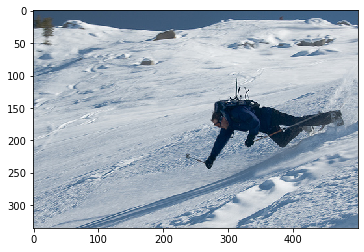

['A skier falling down a hill .', 'A skier is falling face first into the snow .', 'A skier is falling into the snow .', 'A skier falls down a hill .', 'The skier is leaning forward in the snow .']


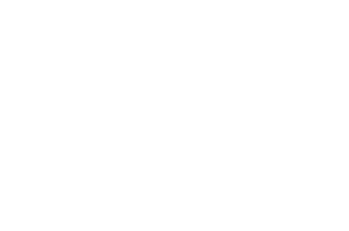

In [13]:
#sample image and captions display:

sample_img_name=list(captions.keys())[4700]

img=cv2.imread(parent_dir+"images/"+sample_img_name)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()
plt.axis("off")

print(captions[sample_img_name])

# Preprocessing the Captions:
##### (Converting to lowercase , removing nos., special characters , adding special symbols to marks start and end of a caption)

In [14]:
def clean_text(text):
    
    '''This function cnverts all characters in the given text to 
       lowercase and also removes numbers and special characters.'''
    
    regex=RegexpTokenizer('[a-z ]+')
    
    text=text.lower()
    text=regex.tokenize(text)
    text=''.join(text)
    text="<s> "+text+" </s>"            
    #<s> marks start of a caption, </s> marks end of the caption, so that model knows when to stop generating more words
    
    return text

In [15]:
for key in list(captions.keys()):
    for i in range(len(captions[key])):
        captions[key][i]=clean_text(captions[key][i])
    
captions

{'1000268201_693b08cb0e.jpg': ['<s> a child in a pink dress is climbing up a set of stairs in an entry way  </s>',
  '<s> a girl going into a wooden building  </s>',
  '<s> a little girl climbing into a wooden playhouse  </s>',
  '<s> a little girl climbing the stairs to her playhouse  </s>',
  '<s> a little girl in a pink dress going into a wooden cabin  </s>'],
 '1001773457_577c3a7d70.jpg': ['<s> a black dog and a spotted dog are fighting </s>',
  '<s> a black dog and a tricolored dog playing with each other on the road  </s>',
  '<s> a black dog and a white dog with brown spots are staring at each other in the street  </s>',
  '<s> two dogs of different breeds looking at each other on the road  </s>',
  '<s> two dogs on pavement moving toward each other  </s>'],
 '1002674143_1b742ab4b8.jpg': ['<s> a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl  </s>',
  '<s> a little girl is sitting in front of a large painted rainbow  </s>',
  '<s> a smal

# Saving Captions in a txt file:

In [12]:
with open("captions.txt",'w') as f:
    f.write(str(captions))

# Loading saved Captions:

In [16]:
with open("captions.txt",'r',encoding='utf-8') as f:
    captions_str=f.read()
    
    json_acceptable_string=captions_str.replace("'","\"")
    captions=json.loads(json_acceptable_string)
    
captions

{'1000268201_693b08cb0e.jpg': ['<s> a child in a pink dress is climbing up a set of stairs in an entry way  </s>',
  '<s> a girl going into a wooden building  </s>',
  '<s> a little girl climbing into a wooden playhouse  </s>',
  '<s> a little girl climbing the stairs to her playhouse  </s>',
  '<s> a little girl in a pink dress going into a wooden cabin  </s>'],
 '1001773457_577c3a7d70.jpg': ['<s> a black dog and a spotted dog are fighting </s>',
  '<s> a black dog and a tricolored dog playing with each other on the road  </s>',
  '<s> a black dog and a white dog with brown spots are staring at each other in the street  </s>',
  '<s> two dogs of different breeds looking at each other on the road  </s>',
  '<s> two dogs on pavement moving toward each other  </s>'],
 '1002674143_1b742ab4b8.jpg': ['<s> a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl  </s>',
  '<s> a little girl is sitting in front of a large painted rainbow  </s>',
  '<s> a smal

# Creating a Vocabulary of all words in the training and testing data:

In [17]:
vocab=[]

for key in captions.keys():
    for sentence in captions[key]:
        for word in sentence.split(' '):
            vocab.append(word)
        
len(vocab)

557629

In [18]:
freq_cnt=dict(Counter(vocab))

In [19]:
#Sort this dictionary according to the freq count
sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

#Filter
threshold=3
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
vocab=[x[0] for x in sorted_freq_cnt if x[0]!='']

In [20]:
len(vocab)

3429

In [21]:
vocab=set(vocab)

In [22]:
word2idx={}
idx2word={}

for i,word in enumerate(vocab):
    word2idx[word]=i+1                                  #we are leaving index 0 to denote pad words
    idx2word[i+1]=word

In [20]:
len(idx2word),len(word2idx)

(3429, 3429)

# Getting the caption of maximum length:
##### (We will specify the maxlen to be equal to the length of this caption, shorter captions will be padded with 0s and longer ones will be clipped (obviously, longer ones are not present))

In [23]:
maxlen=0

for caps in captions.values():
    for cap in caps:
        maxlen=max(maxlen,len(cap.split(' ')))
        
maxlen

40

# Getting the train captions:

In [22]:
train_captions={}

for img in train_imgs:
    train_captions[img]=captions[img]
    
train_captions

{'2947452329_08f2d2a467.jpg': ['<s> a man in a blue shirt is running in a stadium field  </s>',
  '<s> a soccer player in blue  runs  </s>',
  '<s> man in blue and white shorts playing a sport  </s>',
  '<s> soccer player in blue is wiping his mouth with his shirt  </s>',
  '<s> soccer player wipes face with blue jersey  </s>'],
 '3257207516_9d2bc0ea04.jpg': ['<s> a boy and a woman in arab costume making peace signs  </s>',
  '<s> a boy and a young woman in a headscarf make peace signs  </s>',
  '<s> a girl in a headdress and a boy with a bandanna are giving the peace sign to the camera  </s>',
  '<s> a woman wearing a blue headcover and a boy wearing a scarf hold fingers in peace signs  </s>',
  '<s> a woman with a blue headdress and a boy with a headband make a peace sign with their fingers </s>'],
 '440737340_5af34ca9cf.jpg': ['<s> a black man with a red mask is carrying a box  </s>',
  '<s> a man in a domino mask carries an amplifier up a hill  </s>',
  '<s> a man with a mask carry

In [23]:
len(train_captions)

6000

# Image Feature Extraction:

###### (No need to run the below cells, image features have already been extracted and saved in train_data.pkl and test_data.pkl)

In [24]:
model=ResNet50(include_top=False,input_shape=(128,128,3))
model.summary()

c:\users\akshay\anaconda3\envs\tf\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 16, 16, 512)  2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_6 (Add)                     (None, 16, 16, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_18[0][0]              
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 16, 16, 512)  0           add_6[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 8, 8, 256)    131328      activation_21[0][0]              
__________________________________________________________________________________________________
bn4a_branc

__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 4, 4, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_43 (Activation)      (None, 4, 4, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 4, 4, 512)    2359808     activation_43[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 4, 4, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 4, 4, 512)    0           bn5b_branch2b[0][0]              
__________

In [25]:
output_layer=GlobalAvgPool2D()(model.output)
model=Model(model.input,output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 16, 16, 512)  2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_6 (Add)                     (None, 16, 16, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_18[0][0]              
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 16, 16, 512)  0           add_6[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 8, 8, 256)    131328      activation_21[0][0]              
__________________________________________________________________________________________________
bn4a_branc

__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 4, 4, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_43 (Activation)      (None, 4, 4, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 4, 4, 512)    2359808     activation_43[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 4, 4, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 4, 4, 512)    0           bn5b_branch2b[0][0]              
__________

In [26]:
train_ftrs={}
test_ftrs={}

for file in tqdm_notebook(train_imgs):
    
    img=cv2.imread(parent_dir+"images/"+file)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(128,128))
    img=preprocess_input(img)                           #this will scale the image in the same way that is done by resnet 50
    
    ftrs=model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2])).flatten()
    train_ftrs[file]=ftrs
    
       
for file in tqdm_notebook(test_imgs):
    
    img=cv2.imread(parent_dir+"images/"+file)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(128,128))
    img=preprocess_input(img)                           #this will scale the image in the same way that is done by resnet 50
    
    ftrs=model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2])).flatten()
    test_ftrs[file]=ftrs
    
train_ftrs

{'2947452329_08f2d2a467.jpg': array([0.5842838 , 0.04638854, 0.        , ..., 2.7191653 , 0.        ,
        0.92089856], dtype=float32),
 '3257207516_9d2bc0ea04.jpg': array([0.45873505, 0.17936721, 0.        , ..., 0.7009641 , 0.13916408,
        0.1543711 ], dtype=float32),
 '440737340_5af34ca9cf.jpg': array([0.0294124 , 1.6342643 , 3.232885  , ..., 0.16580482, 1.3044039 ,
        0.29282117], dtype=float32),
 '421808539_57abee6d55.jpg': array([0.37026775, 0.727051  , 0.12451033, ..., 2.4742415 , 0.3206278 ,
        0.5104659 ], dtype=float32),
 '1795151944_d69b82f942.jpg': array([1.9577521 , 0.6546232 , 0.07145129, ..., 1.0661563 , 0.05462621,
        0.        ], dtype=float32),
 '2888658480_e922a3dec2.jpg': array([0.02500137, 0.07271357, 0.11773613, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 '2321466753_5606a10721.jpg': array([0.18212028, 0.        , 0.10759811, ..., 0.19949591, 4.267081  ,
        0.07616725], dtype=float32),
 '3677927146_1696f0b075.jpg':

In [27]:
with open("train_ftrs.pkl",'wb') as f:
    pickle.dump(train_ftrs,f)
    
with open("test_ftrs.pkl",'wb') as f:
    pickle.dump(test_ftrs,f)

# Loading the saved features:

In [24]:
with open('train_ftrs.pkl','rb') as f:
    train_ftrs=pickle.load(f)                                     #loading features of train images
    
with open('test_ftrs.pkl','rb') as f:
    test_ftrs=pickle.load(f)                                      #loading features of test images
    
train_ftrs

{'2947452329_08f2d2a467.jpg': array([0.5842838 , 0.04638854, 0.        , ..., 2.7191653 , 0.        ,
        0.92089856], dtype=float32),
 '3257207516_9d2bc0ea04.jpg': array([0.45873505, 0.17936721, 0.        , ..., 0.7009641 , 0.13916408,
        0.1543711 ], dtype=float32),
 '440737340_5af34ca9cf.jpg': array([0.0294124 , 1.6342643 , 3.232885  , ..., 0.16580482, 1.3044039 ,
        0.29282117], dtype=float32),
 '421808539_57abee6d55.jpg': array([0.37026775, 0.727051  , 0.12451033, ..., 2.4742415 , 0.3206278 ,
        0.5104659 ], dtype=float32),
 '1795151944_d69b82f942.jpg': array([1.9577521 , 0.6546232 , 0.07145129, ..., 1.0661563 , 0.05462621,
        0.        ], dtype=float32),
 '2888658480_e922a3dec2.jpg': array([0.02500137, 0.07271357, 0.11773613, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 '2321466753_5606a10721.jpg': array([0.18212028, 0.        , 0.10759811, ..., 0.19949591, 4.267081  ,
        0.07616725], dtype=float32),
 '3677927146_1696f0b075.jpg':

# Making a Custom Data Loader:

##### (Since the data is very big, we will load it in small batches)

In [29]:
def data_generator(img_ftrs,captions,batch_size,maxlen,word2idx):
    
    '''This function is used to load the data, one batch at a time'''
    
    x1=[]                              #will store the captions data
    x2=[]                              #will store the features of each image
    y_true=[]                          #will store the actual next word
    
    n=0                                  
    #to count no. of images generated for the current batch, will be reset to zero after generation of every batch
    
    for img,caps in captions.items():

        ftrs=img_ftrs[img]                                                     
        #feature vector of the current image generated using RESNET 50 model

        for cap in caps:
            cap=cap.split(' ')
            cap=[word2idx[word] for word in cap if word in word2idx]           #converting words to indices

            for i in range(1,len(cap)):
                xi=cap[:i]                              #first i words in the caption will be the current x_train (for captions)
                yi=cap[i]                               #ith word will be the y_true (actual truth for xi)

                xi=sequence.pad_sequences([xi],maxlen=maxlen,value=0,padding='post')[0]          
                #only pads 2d arrays, therefore we have enclosed xi within a list. Later 
                #we are fetching 0th element of the padded 2d list to get the padded 1d xi

                yi=to_categorical(yi,num_classes=len(vocab)+1)

                x1.append(xi)
                y_true.append(yi)
                x2.append(ftrs)

        n+=1
        if n==batch_size:                                #when to return a batch
            
            yield ([np.array(x2),np.array(x1)],np.array(y_true))
                
            #reset x1,x2,y_true and n
            x1=[]
            x2=[]
            y_true=[]
            n=0

# Creating an Embedding Matrix:
##### (This will be used in the embedding layer)
##### (We will use glove embedding to create the matrix)

In [30]:
with open('glove.6B.50d.txt','r',encoding='utf-8') as f:
    text=f.read()
    
len(text)

171337876

In [31]:
embeddings={}

for line in tqdm_notebook(text.split('\n')):
    
    line=line.split(' ')
    word=line[0]
    emb=line[1:]
    
    embeddings[word]=np.array(emb,dtype='float')
    
embeddings

{'the': array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01]),
 ',': array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
        -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
        -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
        -0.41634 , -0.15428 ,  0.1

In [32]:
embedding_matrix=np.zeros((len(vocab)+1,50))                   #each glove vector is of size 50                
embedding_matrix

#creating a matrix containing all 0s, we will replace the 0s with 
#actual embeddings of the words correspondng to the indices. If some 
#word in the vocabulary does not have a glove embedding, we will let 
#it's embedding in the embedding matrix be a row of all 0s.

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
count=0
for i in range(len(vocab)+1):
    
    if idx2word.get(i) is None:
        continue
    
    word=idx2word[i]
    
    if embeddings.get(word) is None:
        count+=1
        continue
        
    emb=embeddings[word]
    embedding_matrix[i]=emb
    
embedding_matrix

#words which are not present in glove embedding and pad sequences are given an embedding of all zeroes

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.99159 ,  1.4875  , -0.54479 , ..., -0.5278  ,  0.46497 ,
        -0.70604 ],
       [-0.36476 , -0.022545,  0.59254 , ..., -0.33465 ,  0.29469 ,
        -1.4973  ],
       ...,
       [ 0.49652 , -0.65143 , -1.0869  , ..., -0.32005 ,  0.4658  ,
        -0.10813 ],
       [-0.69461 ,  0.57135 , -0.30759 , ..., -0.56407 , -0.19162 ,
        -1.3292  ],
       [-0.42105 , -0.53977 ,  0.3446  , ...,  0.04665 ,  0.58348 ,
        -1.0894  ]])

# Creating a Model:

In [34]:
img_ftrs_shape=list(train_ftrs.values())[0].shape
img_ftrs_shape

(2048,)

In [35]:
img_captions_shape=(maxlen,)
img_captions_shape

(40,)

In [36]:
#Model for image features. This will take the image features as 
#input and output a 256 sized vector which encodes the images

input_img=Input(shape=img_ftrs_shape)
dropout_img=Dropout(0.4)(input_img)
encoded_img=Dense(256,activation='relu')(dropout_img)

W0412 11:38:04.996923 11792 deprecation.py:506] From c:\users\akshay\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [37]:
#Model for image captions. This will take partial captions
#as input and output an encoding of the captions

input_caps=Input(shape=img_captions_shape)
emb_out=Embedding(input_dim=len(vocab)+1,output_dim=50,mask_zero=True)(input_caps)               
#mask_zero=True means that index 0 is used for padding only

dropout_caps=Dropout(0.4)(emb_out)
encoded_caps=LSTM(256)(dropout_caps)

W0412 11:38:05.078399 11792 deprecation.py:506] From c:\users\akshay\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0412 11:38:05.731546 11792 deprecation.py:323] From c:\users\akshay\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\backend.py:3794: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [38]:
#Combining the Image and Captions Models:

comb=Add()([encoded_img,encoded_caps])                         #see documentation of Add layer

dense=Dense(256,activation="relu")(comb)
output=Dense(len(vocab)+1,activation='softmax')(dense)

model=Model(inputs=[input_img,input_caps],outputs=output)

In [39]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 50)       171500      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [40]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

#This will set the weights of the embedding layer same as embedding_matrix as embedding_matrix has been built using 
#pre-trained glove embeddings. So we are using transfer learning here and hence do not need to train the Embedding layer.

In [41]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 50)       171500      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [42]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

# Training the Model:

In [43]:
epochs=20
batch_size=3
steps_per_epoch=len(train_captions)//batch_size                

#steps per epoch specifies how many batches are there in one epoch 
#(it will be equal to (no. of images)//(batch_size))

In [44]:
for i in range(epochs):
    
    generator=data_generator(batch_size=batch_size,captions=train_captions,img_ftrs=train_ftrs,maxlen=maxlen,word2idx=word2idx)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps_per_epoch,verbose=1)
    model.save("model.h5")

 314/2000 [===>..........................] - ETA: 3:07:11 - loss: 8.35 - ETA: 1:40:16 - loss: 8.09 - ETA: 1:11:44 - loss: 7.78 - ETA: 57:26 - loss: 7.5547 - ETA: 48:51 - loss: 7.43 - ETA: 43:05 - loss: 7.29 - ETA: 39:00 - loss: 7.19 - ETA: 35:56 - loss: 7.00 - ETA: 33:36 - loss: 6.91 - ETA: 31:38 - loss: 6.83 - ETA: 30:00 - loss: 6.76 - ETA: 28:47 - loss: 6.71 - ETA: 27:47 - loss: 6.65 - ETA: 26:59 - loss: 6.55 - ETA: 26:05 - loss: 6.49 - ETA: 25:24 - loss: 6.45 - ETA: 24:48 - loss: 6.42 - ETA: 24:08 - loss: 6.35 - ETA: 23:43 - loss: 6.30 - ETA: 23:18 - loss: 6.27 - ETA: 22:56 - loss: 6.22 - ETA: 22:36 - loss: 6.19 - ETA: 22:17 - loss: 6.15 - ETA: 21:56 - loss: 6.13 - ETA: 21:38 - loss: 6.11 - ETA: 21:17 - loss: 6.09 - ETA: 21:00 - loss: 6.08 - ETA: 20:47 - loss: 6.06 - ETA: 20:36 - loss: 6.05 - ETA: 20:23 - loss: 6.05 - ETA: 20:10 - loss: 6.03 - ETA: 20:00 - loss: 6.03 - ETA: 19:51 - loss: 6.01 - ETA: 19:43 - loss: 5.98 - ETA: 19:33 - loss: 5.96 - ETA: 19:23 - loss: 5.95 - ETA: 19:15 

 628/2000 [========>.....................] - ETA: 12:57 - loss: 5.04 - ETA: 12:57 - loss: 5.04 - ETA: 12:56 - loss: 5.04 - ETA: 12:56 - loss: 5.03 - ETA: 12:55 - loss: 5.03 - ETA: 12:55 - loss: 5.03 - ETA: 12:55 - loss: 5.03 - ETA: 12:54 - loss: 5.03 - ETA: 12:54 - loss: 5.02 - ETA: 12:53 - loss: 5.02 - ETA: 12:53 - loss: 5.02 - ETA: 12:52 - loss: 5.02 - ETA: 12:51 - loss: 5.02 - ETA: 12:50 - loss: 5.02 - ETA: 12:50 - loss: 5.02 - ETA: 12:49 - loss: 5.01 - ETA: 12:48 - loss: 5.01 - ETA: 12:48 - loss: 5.01 - ETA: 12:47 - loss: 5.01 - ETA: 12:47 - loss: 5.01 - ETA: 12:46 - loss: 5.00 - ETA: 12:46 - loss: 5.00 - ETA: 12:46 - loss: 5.00 - ETA: 12:46 - loss: 5.00 - ETA: 12:45 - loss: 5.00 - ETA: 12:45 - loss: 4.99 - ETA: 12:44 - loss: 4.99 - ETA: 12:44 - loss: 4.99 - ETA: 12:43 - loss: 4.99 - ETA: 12:43 - loss: 4.99 - ETA: 12:43 - loss: 4.99 - ETA: 12:42 - loss: 4.99 - ETA: 12:42 - loss: 4.98 - ETA: 12:42 - loss: 4.98 - ETA: 12:41 - loss: 4.98 - ETA: 12:41 - loss: 4.98 - ETA: 12:40 - loss: 

 942/2000 [=============>................] - ETA: 10:32 - loss: 4.70 - ETA: 10:32 - loss: 4.70 - ETA: 10:31 - loss: 4.70 - ETA: 10:31 - loss: 4.70 - ETA: 10:30 - loss: 4.69 - ETA: 10:29 - loss: 4.69 - ETA: 10:29 - loss: 4.69 - ETA: 10:28 - loss: 4.69 - ETA: 10:28 - loss: 4.69 - ETA: 10:28 - loss: 4.69 - ETA: 10:27 - loss: 4.69 - ETA: 10:27 - loss: 4.69 - ETA: 10:26 - loss: 4.69 - ETA: 10:26 - loss: 4.68 - ETA: 10:26 - loss: 4.68 - ETA: 10:25 - loss: 4.68 - ETA: 10:25 - loss: 4.68 - ETA: 10:24 - loss: 4.68 - ETA: 10:24 - loss: 4.68 - ETA: 10:24 - loss: 4.68 - ETA: 10:23 - loss: 4.68 - ETA: 10:23 - loss: 4.68 - ETA: 10:23 - loss: 4.68 - ETA: 10:22 - loss: 4.68 - ETA: 10:22 - loss: 4.68 - ETA: 10:22 - loss: 4.68 - ETA: 10:21 - loss: 4.68 - ETA: 10:21 - loss: 4.68 - ETA: 10:21 - loss: 4.67 - ETA: 10:20 - loss: 4.67 - ETA: 10:20 - loss: 4.67 - ETA: 10:19 - loss: 4.67 - ETA: 10:19 - loss: 4.67 - ETA: 10:19 - loss: 4.67 - ETA: 10:18 - loss: 4.67 - ETA: 10:18 - loss: 4.67 - ETA: 10:17 - loss: 

1256/2000 [=================>............] - ETA: 8:07 - loss: 4.495 - ETA: 8:06 - loss: 4.494 - ETA: 8:06 - loss: 4.493 - ETA: 8:05 - loss: 4.492 - ETA: 8:05 - loss: 4.491 - ETA: 8:04 - loss: 4.491 - ETA: 8:04 - loss: 4.490 - ETA: 8:03 - loss: 4.489 - ETA: 8:03 - loss: 4.488 - ETA: 8:02 - loss: 4.488 - ETA: 8:02 - loss: 4.487 - ETA: 8:01 - loss: 4.487 - ETA: 8:01 - loss: 4.486 - ETA: 8:00 - loss: 4.485 - ETA: 8:00 - loss: 4.485 - ETA: 7:59 - loss: 4.484 - ETA: 7:59 - loss: 4.484 - ETA: 7:58 - loss: 4.484 - ETA: 7:58 - loss: 4.483 - ETA: 7:57 - loss: 4.483 - ETA: 7:57 - loss: 4.482 - ETA: 7:56 - loss: 4.481 - ETA: 7:56 - loss: 4.481 - ETA: 7:56 - loss: 4.480 - ETA: 7:55 - loss: 4.480 - ETA: 7:55 - loss: 4.479 - ETA: 7:54 - loss: 4.479 - ETA: 7:54 - loss: 4.478 - ETA: 7:53 - loss: 4.478 - ETA: 7:53 - loss: 4.477 - ETA: 7:53 - loss: 4.476 - ETA: 7:52 - loss: 4.475 - ETA: 7:52 - loss: 4.475 - ETA: 7:51 - loss: 4.475 - ETA: 7:51 - loss: 4.475 - ETA: 7:50 - loss: 4.474 - ETA: 7:50 - loss: 4

1570/2000 [======================>.......] - ETA: 5:41 - loss: 4.354 - ETA: 5:41 - loss: 4.354 - ETA: 5:41 - loss: 4.353 - ETA: 5:40 - loss: 4.352 - ETA: 5:40 - loss: 4.352 - ETA: 5:39 - loss: 4.351 - ETA: 5:39 - loss: 4.351 - ETA: 5:38 - loss: 4.351 - ETA: 5:38 - loss: 4.351 - ETA: 5:37 - loss: 4.351 - ETA: 5:37 - loss: 4.350 - ETA: 5:37 - loss: 4.349 - ETA: 5:36 - loss: 4.349 - ETA: 5:36 - loss: 4.349 - ETA: 5:35 - loss: 4.348 - ETA: 5:35 - loss: 4.348 - ETA: 5:34 - loss: 4.347 - ETA: 5:34 - loss: 4.348 - ETA: 5:33 - loss: 4.348 - ETA: 5:33 - loss: 4.347 - ETA: 5:33 - loss: 4.346 - ETA: 5:32 - loss: 4.346 - ETA: 5:32 - loss: 4.345 - ETA: 5:31 - loss: 4.345 - ETA: 5:31 - loss: 4.345 - ETA: 5:30 - loss: 4.345 - ETA: 5:30 - loss: 4.344 - ETA: 5:30 - loss: 4.344 - ETA: 5:29 - loss: 4.344 - ETA: 5:29 - loss: 4.343 - ETA: 5:28 - loss: 4.343 - ETA: 5:28 - loss: 4.343 - ETA: 5:27 - loss: 4.342 - ETA: 5:27 - loss: 4.342 - ETA: 5:26 - loss: 4.341 - ETA: 5:26 - loss: 4.341 - ETA: 5:25 - loss: 4

1885/2000 [===========================>..] - ETA: 3:17 - loss: 4.248 - ETA: 3:16 - loss: 4.248 - ETA: 3:16 - loss: 4.247 - ETA: 3:15 - loss: 4.247 - ETA: 3:15 - loss: 4.246 - ETA: 3:14 - loss: 4.246 - ETA: 3:14 - loss: 4.246 - ETA: 3:14 - loss: 4.245 - ETA: 3:13 - loss: 4.245 - ETA: 3:13 - loss: 4.244 - ETA: 3:12 - loss: 4.244 - ETA: 3:12 - loss: 4.244 - ETA: 3:11 - loss: 4.244 - ETA: 3:11 - loss: 4.244 - ETA: 3:10 - loss: 4.244 - ETA: 3:10 - loss: 4.243 - ETA: 3:09 - loss: 4.243 - ETA: 3:09 - loss: 4.242 - ETA: 3:09 - loss: 4.242 - ETA: 3:08 - loss: 4.242 - ETA: 3:08 - loss: 4.242 - ETA: 3:07 - loss: 4.241 - ETA: 3:07 - loss: 4.241 - ETA: 3:06 - loss: 4.241 - ETA: 3:06 - loss: 4.241 - ETA: 3:05 - loss: 4.240 - ETA: 3:05 - loss: 4.240 - ETA: 3:05 - loss: 4.240 - ETA: 3:04 - loss: 4.240 - ETA: 3:04 - loss: 4.239 - ETA: 3:03 - loss: 4.239 - ETA: 3:03 - loss: 4.239 - ETA: 3:02 - loss: 4.239 - ETA: 3:02 - loss: 4.238 - ETA: 3:01 - loss: 4.239 - ETA: 3:01 - loss: 4.238 - ETA: 3:00 - loss: 4

  81/2000 [>.............................] - ETA: 18:34 - loss: 4.08 - ETA: 16:57 - loss: 4.02 - ETA: 16:36 - loss: 3.69 - ETA: 17:24 - loss: 3.61 - ETA: 18:03 - loss: 3.70 - ETA: 18:19 - loss: 3.62 - ETA: 18:17 - loss: 3.65 - ETA: 17:45 - loss: 3.59 - ETA: 17:46 - loss: 3.62 - ETA: 17:26 - loss: 3.62 - ETA: 17:02 - loss: 3.58 - ETA: 16:47 - loss: 3.59 - ETA: 16:49 - loss: 3.60 - ETA: 16:53 - loss: 3.56 - ETA: 16:53 - loss: 3.53 - ETA: 16:44 - loss: 3.56 - ETA: 16:44 - loss: 3.58 - ETA: 16:32 - loss: 3.58 - ETA: 16:34 - loss: 3.55 - ETA: 16:40 - loss: 3.57 - ETA: 16:44 - loss: 3.55 - ETA: 16:46 - loss: 3.56 - ETA: 16:45 - loss: 3.53 - ETA: 16:44 - loss: 3.54 - ETA: 16:45 - loss: 3.55 - ETA: 16:41 - loss: 3.55 - ETA: 16:39 - loss: 3.55 - ETA: 16:41 - loss: 3.56 - ETA: 16:47 - loss: 3.57 - ETA: 16:48 - loss: 3.59 - ETA: 16:46 - loss: 3.61 - ETA: 16:49 - loss: 3.62 - ETA: 16:53 - loss: 3.62 - ETA: 17:01 - loss: 3.60 - ETA: 17:03 - loss: 3.61 - ETA: 17:09 - loss: 3.62 - ETA: 17:10 - loss: 

KeyboardInterrupt: 

# Loading the Trained Model:

In [6]:
model=load_model("model.h5")
model.summary()

W0412 14:52:47.070980  8868 deprecation.py:506] From c:\users\akshay\anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0412 14:52:47.139538  8868 deprecation.py:506] From c:\users\akshay\anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0412 14:52:47.567285  8868 deprecation.py:323] From c:\users\akshay\anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\keras\backend.py:3994: where (from tensorflow.python.ops.arr

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 50)       171500      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

# Predictions:

In [25]:
def predict(ftrs):                                
    #ftrs represents the image features extracted using resnet and saved in test_data dictionary
    
    input_string='<s>'                            #intial input will be the start sequence
    
    for i in range(maxlen):                       #we will generate captions of maximum length equal to maxlen
        
        input_seq=[word2idx[word] for word in input_string.split(' ')]            
        #converting each word to a number (it's corresponding index)
        
        input_sequence=np.array(sequence.pad_sequences([input_seq],maxlen=maxlen,padding='post')[0])
        input_sequence=input_sequence.reshape((1,input_sequence.shape[0]))
        
        pred=model.predict([ftrs,input_sequence])
        idx=pred.argmax()                         #getting the index of the word which has maximum probability
        word=idx2word[idx]                        #getting the actual predicted word
        
        input_string+=' '+word
        
        if word=='</s>':                          #stop when end of sequence word is encountered
            break
    
    predicted_caption=input_string.split(' ')[1:-1]         #removing the start and end special words (<s> and </s>)
    predicted_caption=' '.join(predicted_caption)           #converting predicted caption to string
    
    return predicted_caption

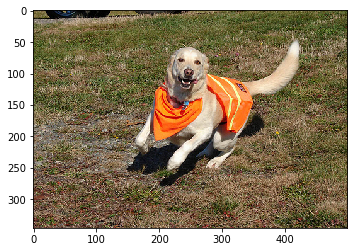

break photographed city gentleman center photographed car rainbow photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


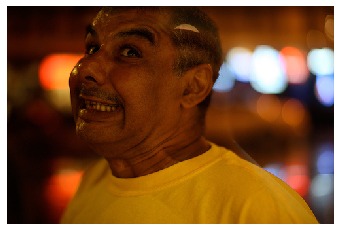

monitor balls crane note note photographed hall photographed hall photographed master note photographed master fresh photographed master photographed master master fresh bare photographed photographed photographed photographed photographed photographed photographed photographed master master potato photographed serve photographed photographed photographed photographed


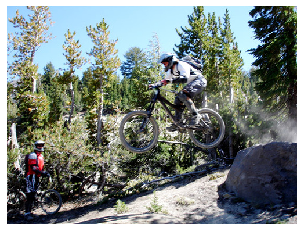

opposite city gentleman country photographed mountainside vests photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed lifted photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


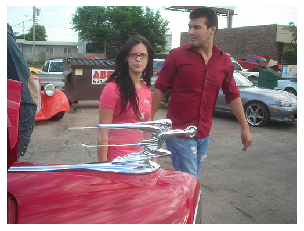

bicycles photographed digging brunette nap glasses mountainside backpacker city mountainside hands pad photographed mountainside hitting photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed gazes photographed gazes photographed


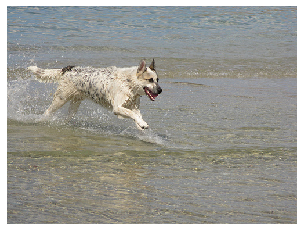

ankle city lifted photographed traffic photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


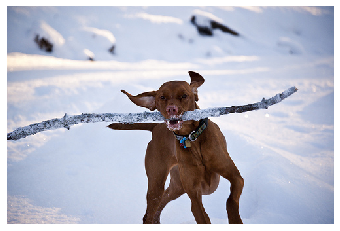

city gentleman flyer photographed mountainside singing photographed mountainside ponytail photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


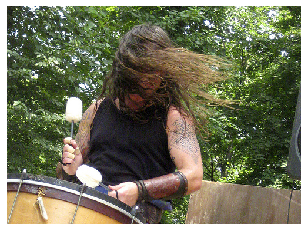

cheering photographed button photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


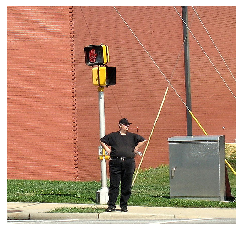

bicycles photographed digging brunette purple reddish cartwheel leads photographed checking trumpet wood gentleman teammate photographed mountainside turtle boardwalk fresh bare photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


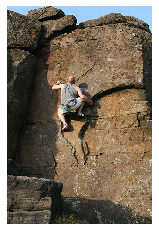

bicycles climb photographed award photographed photographed together photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed lifted photographed photographed what photographed what photographed


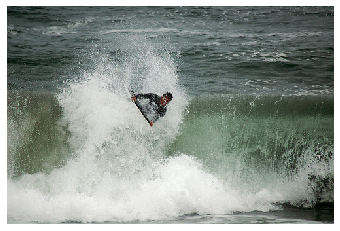

bicycles city gentleman record photographed boys photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


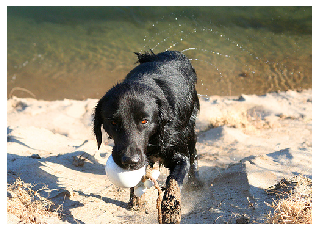

kneeling city lifted photographed mountainside number photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


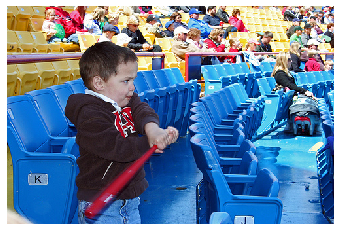

kitchen city mountainside mom attention photographed mountainside relax photographed gentleman master photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


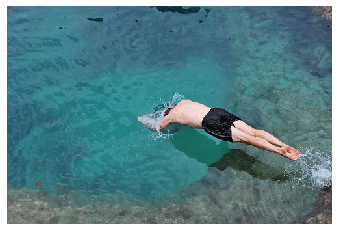

bicycles city gentleman challenging photographed ski photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed lifted photographed photographed together photographed photographed together photographed photographed together photographed photographed photographed photographed photographed photographed photographed photographed photographed


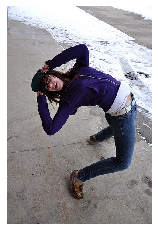

bicycles giving boardwalk gentleman flyer photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


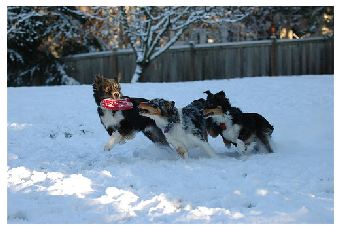

city gentleman flyer photographed mountainside cutting firetruck photographed photographed photographed photographed firetruck photographed photographed firetruck photographed photographed photographed firetruck photographed firetruck photographed photographed photographed firetruck photographed heels photographed photographed photographed heels photographed photographed photographed heels photographed photographed photographed heels


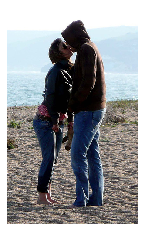

opposite photographed blocks photographed photographed mountainside dance bicycles photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


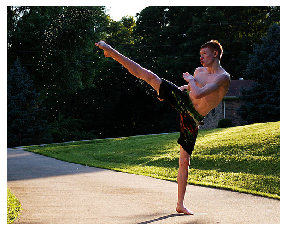

city mountainside tattoos faded brunette competition peeking mountainside reading middleaged photographed mountainside backpacker city mountainside hands pad trumpet photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed beauty photographed photographed photographed photographed


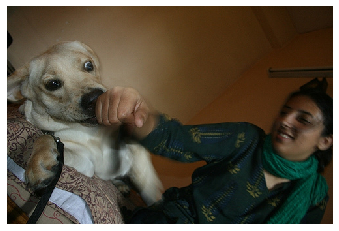

wine city leash photographed photographed mountainside dirt photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


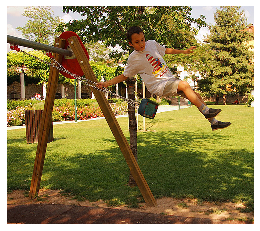

bicycles city gentleman challenging photographed mountainside hospital photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


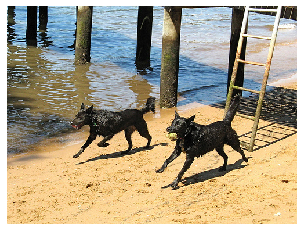

thumb city gentleman challenging photographed mountainside vests photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed gazes photographed


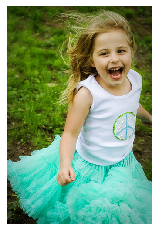

city wakeboards photographed mountainside backpacker city tattoos eats reddish center photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


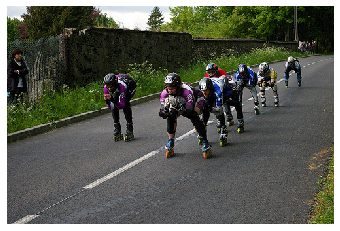

type little reddish mountainside hangs teammate photographed airport photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


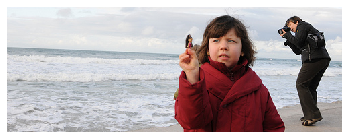

photographed city gentleman flyer photographed mountainside backpacker tan photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


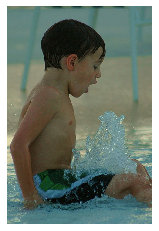

city tattoos leashes brunette carried city mountainside dollar photographed photographed tattoos lifted photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


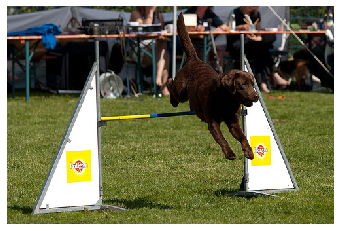

clearing singing fly mountainside singing orange mountainside singing photographed mountainside day photographed mountainside buckets class heron skyscraper involving photographed mountainside backpacker tan photographed photographed jumper photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


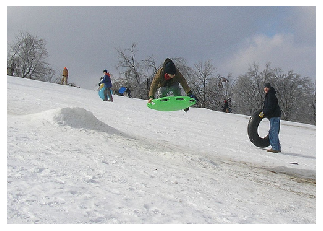

banner city gentleman flyer photographed mountainside backpacker city pushed hard photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


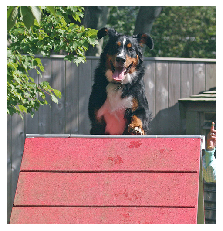

cheering photographed button photographed button photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


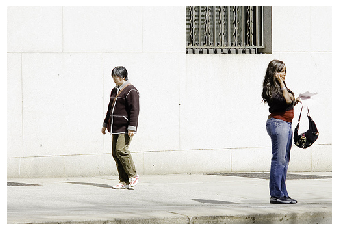

banner photographed city gentleman challenging photographed mountainside hitting photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


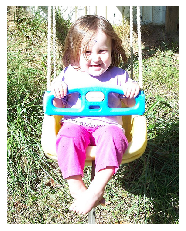

reddish mountainside festival photographed photographed photographed photographed photographed photographed photographed photographed photographed gondola photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed decorative photographed decorative photographed photographed photographed photographed photographed


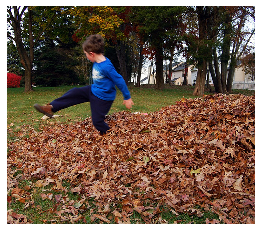

city mountainside sparklers parachutes photographed mountainside backpacker city mountainside ceremony faded fly tattoos faded brunette purple reddish mountainside performance photographed photographed mountainside backpacker city mountainside ceremony faded photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


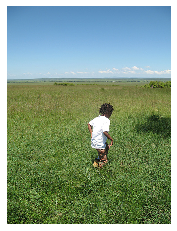

cliff city gentleman challenging photographed mountainside backpacker city mountainside ceremony faded photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


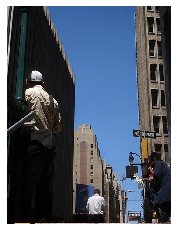

photographed photographed photographed outcropping photographed falls photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed hall photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


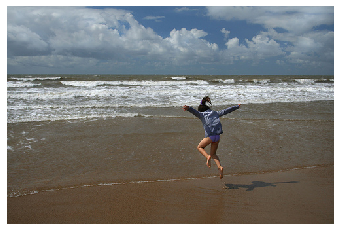

city gentleman challenging photographed braids mountainside day photographed gentleman record photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


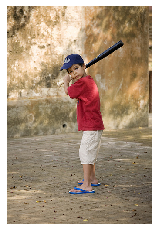

bicycles city gentleman challenging photographed young mountainside very photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


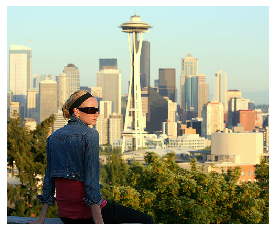

photographed city drinks boardwalk mountainside turtle photographed fresh bare photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


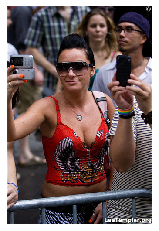

bridal photographed opens mountainside turtle boardwalk fresh bare photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed photographed


KeyboardInterrupt: 

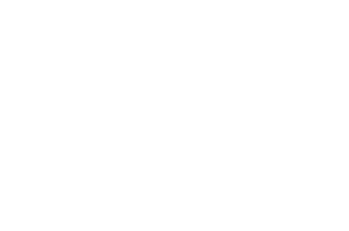

In [26]:
for img,ftrs in list(test_ftrs.items())[:50]:               #predicting for the first 50 images of the test set
    
    caption=predict(ftrs.reshape(1,ftrs.shape[0]))          
    #reshaping to (1,2048) because we need to send input in the form of batches, therefore, 1 image of size 2048
    
    img=cv2.imread(parent_dir+'images/'+img)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.show()
    plt.axis("off")
    
    print(caption)